### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

We then need to install *ktrain* library using pip.

In [2]:
!pip install -q ktrain

     |████████████████████████████████| 25.3MB 117kB/s 
     |████████████████████████████████| 6.8MB 53.7MB/s 
     |████████████████████████████████| 983kB 41.8MB/s 
     |████████████████████████████████| 266kB 58.9MB/s 
     |████████████████████████████████| 1.9MB 45.9MB/s 
     |████████████████████████████████| 1.2MB 48.9MB/s 
     |████████████████████████████████| 471kB 51.3MB/s 
     |████████████████████████████████| 3.2MB 42.5MB/s 
     |████████████████████████████████| 890kB 52.9MB/s 


In [3]:
import ktrain
print(ktrain.__version__)

0.26.2


### Load a Dataset Into Arrays

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Kaggle/News

In [4]:
import numpy as np
import pandas as pd
train_data = pd.DataFrame(pd.read_csv('train.csv'))
test_data = pd.DataFrame(pd.read_csv('test_without_target.csv'))

import numpy as np
from sklearn.model_selection import train_test_split
x_train, y_train,x_test,y_test=train_test_split(train_data.iloc[:,2:3],train_data.iloc[:,4:6],test_size=0.25,random_state=123)

## STEP 1:  Preprocess Data and Create a Transformer Model

In [5]:
y_train['text'].values.shape

(4045,)

In [6]:
import ktrain
from ktrain import text
MODEL_NAME = 'youscan/ukr-roberta-base'
categories = [0, 1 , 2, 3 , 4 , 5, 6]
t = text.Transformer(MODEL_NAME, maxlen=500, classes=categories)
trn = t.preprocess_train(x_train['text'].values, x_test['source'].values)
val = t.preprocess_test(y_train['text'].values, y_test['source'].values)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:414: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')



preprocessing train...
language: uk
train sequence lengths:
	mean : 385
	95percentile : 1327
	99percentile : 2257


Is Multi-Label? False
preprocessing test...
language: uk
test sequence lengths:
	mean : 388
	95percentile : 1292
	99percentile : 2204


404 Client Error: Not Found for url: https://huggingface.co/youscan/ukr-roberta-base/resolve/main/tf_model.h5


## STEP 2:  Train the Model

In [7]:
learner.fit_onecycle(5e-5, 3)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/3
2022/2022 [==============================] - 3126s 2s/step - loss: 0.8415 - accuracy: 0.7177 - val_loss: 0.2408 - val_accuracy: 0.9310
Epoch 2/3
2022/2022 [==============================] - 3108s 2s/step - loss: 0.2586 - accuracy: 0.9234 - val_loss: 0.2731 - val_accuracy: 0.9204
Epoch 3/3
2022/2022 [==============================] - 3132s 2s/step - loss: 0.1204 - accuracy: 0.9629 - val_loss: 0.1420 - val_accuracy: 0.9562


## STEP 3: Evaluate and Inspect the Model

In [8]:
learner.validate(class_names=t.get_classes())

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       434
           1       0.96      0.97      0.97       879
           2       0.94      0.86      0.90       259
           3       0.96      0.93      0.95       533
           4       0.92      0.97      0.94       663
           5       0.95      0.96      0.95       388
           6       0.98      0.97      0.98       889

    accuracy                           0.96      4045
   macro avg       0.95      0.95      0.95      4045
weighted avg       0.96      0.96      0.96      4045



array([[415,   2,   1,   2,   3,   8,   3],
       [  0, 857,   3,   5,   1,   1,  12],
       [  0,   0, 224,   0,  35,   0,   0],
       [  5,   9,   2, 496,   9,   9,   3],
       [  5,   3,   6,   7, 640,   2,   0],
       [  5,   2,   2,   5,   3, 371,   0],
       [  2,  18,   1,   1,   1,   1, 865]])

In [9]:
learner.view_top_losses(n=1, preproc=t)

----------
id:1278 | loss:8.21 | true:4 | pred:1)



In [ ]:
print(x_test[371])

## STEP 4: Making Predictions on New Data in Deployment

In [10]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [11]:
predictor.save('/tmp/predictor')

In [14]:
reloaded_predictor = ktrain.load_predictor('/tmp/predictor')

In [12]:
predicted = predictor.predict(test_data['text'].values)

(array([1729., 3471.,    0.,  918.,    0., 2216., 2719.,    0., 1557.,
        3573.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

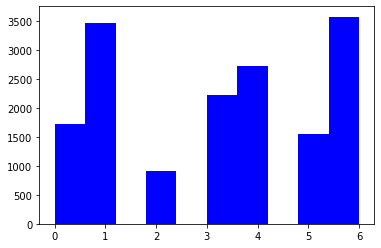

In [19]:
import matplotlib.pyplot as plt
plt.hist(predicted, color='blue')

In [22]:
predicted.count(6)

3573

In [17]:
ids = test_data.iloc[:,[0]]
ids = list(map(lambda x: int(x),np.array(ids)))
res = zip(ids, predicted)
res = list(map(lambda x: {"Id": x[0], "Predicted": int(x[1])}, list(res)))
res
import csv
from google.colab import files
with open("result.csv", "w", newline="") as file:
  columns = ["Id", "Predicted"]
  writer = csv.DictWriter(file, fieldnames=columns)
  writer.writeheader()
  print(len(res))
  writer.writerows(res)
  files.download("result.csv")

16183


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>